# Zestaw 6. Układy równań liniowych

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.linalg
from time import time

## 1. Metoda Gaussa-Jordana

<i> Napisz i sprawdź funkcję rozwiązującą układ równań liniowych n × n metodą Gaussa-Jordana. </i> 

In [2]:
def gauss_jordan(A, B):
    n = A.shape[0]
    
    A = A.copy()
    B = B.copy()
    
    for i in range(n):
        p = i
        while p < n and A[p, i] == 0:
            p += 1
            
        if p == n:
            print('no solution')
            return
        
        A[[p, i]] = A[[i, p]]
        B[[p, i]] = B[[p, i]]
        
        for j in range(n):
            if j != i:
                B[j] -= (A[j, i]/A[i, i])* B[i]
                A[j,:] -= (A[j, i]/A[i, i])* A[i,:]
    
    return B/np.diag(A)

In [3]:
A = np.array([[1,1,1], [1,2,3], [4,2,1]], dtype=float)
B = np.array([3, 6, 7], dtype=float)

print(f'implemented function: {gauss_jordan(A, B)}')
print(f'numpy: {np.linalg.solve(A, B)}')

implemented function: [1. 1. 1.]
numpy: [1. 1. 1.]


In [4]:
def test_gauss_jordan(n):
    A = np.random.rand(n, n)
    B = np.random.rand(n)
    
    try:
        np_result = np.linalg.solve(A, B).flatten()
    except:
        print('singular matrix')
        return
        
    jordan_result = gauss_jordan(A, B)
    
    print(f'implemented function: [{jordan_result[0]}, (...)]')
    print(f'numpy: [{np_result[0]}, (...)]')
    print(f'close?: {np.allclose(np_result, jordan_result)}\n')

In [5]:
test_gauss_jordan(3)
test_gauss_jordan(10)
test_gauss_jordan(500)

implemented function: [2.902671706662034, (...)]
numpy: [2.9026717066620336, (...)]
close?: True

implemented function: [2.133413190596718, (...)]
numpy: [2.13341319059672, (...)]
close?: True

implemented function: [-0.482664912365306, (...)]
numpy: [-0.48266491235631453, (...)]
close?: True



<i>Dla rozmiarów macierzy współczynników większych niż 500 × 500 porównaj czasy działania zaimplementowanej funkcji z czasami uzyskanymi dla wybranych funkcji bibliotecznych. Opisz wyniki i podaj zalety i wady w stosunku do metody eliminacji Gaussa.
</i>

In [6]:
def compare_times_gauss_jordan(n_min, n_max, step):
    
    np_times = []
    jordan_times = []
    scipy_times = []
    ns = []
    
    for n in range(n_min, n_max+1, step):
        A = np.random.rand(n, n)
        B = np.random.rand(n)
        
        start = time()
        try:
            np.linalg.solve(A, B).flatten()
        except:
            continue
        end = time()
        np_times.append(end-start)
        
        start = time()
        scipy.linalg.solve(A, B).flatten()
        end = time()
        scipy_times.append(end-start)

        start = time()
        gauss_jordan(A, B)
        end = time()
        jordan_times.append(end-start)
        ns.append(n)
    
    fig, ax = plt.subplots()
    ax.plot(ns, np_times, label='numpy', color='darksalmon', marker='o', linewidth=2)
    ax.plot(ns, jordan_times, label='gauss-jordan', color='skyblue', marker='o', linewidth=2)
    ax.plot(ns, scipy_times, label='scipy', color='lightpink', marker='o', linewidth=2)
    ax.legend()
    
    for n, numpy, scipy_, jordan in zip(ns, np_times, scipy_times, jordan_times):
        print(f'n: {n}, numpy: {numpy:.3f}, scipy: {scipy_:.3f}, implemented gauss-jordan: {jordan:.3f}')
    plt.show()

n: 500, numpy: 0.061, scipy: 0.120, implemented gauss-jordan: 0.902
n: 600, numpy: 0.010, scipy: 0.034, implemented gauss-jordan: 1.361
n: 700, numpy: 0.007, scipy: 0.102, implemented gauss-jordan: 1.929
n: 800, numpy: 0.008, scipy: 0.035, implemented gauss-jordan: 2.633
n: 900, numpy: 0.011, scipy: 0.037, implemented gauss-jordan: 3.439
n: 1000, numpy: 0.012, scipy: 0.100, implemented gauss-jordan: 4.380


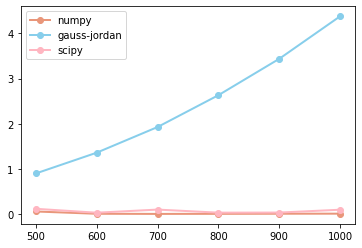

In [7]:
compare_times_gauss_jordan(500, 1000, step=100)

Zaimplementowana funkcja poprawnie znajduje rozwiązanie układu równań w każdym przypadku. Czas jej działania, zgodnie z oczekiwanymi był większy niż w przypadku wykorzystania dedykowanych funkcji bibliotecznych. Zasakakujące było to, jak dużą przewagę mają implementacje biblioteczne, gdzie czas działania zdaje się nie zależeć od wielkości macierzy. Wynika to najpewniej z zaawansowanych technik rozwiązywania układów równań użytych przez twórców biblioteki oraz tego, że moduły te używają bezpośrednio języka C.

Zaletą metody Gaussa-Jordana, w stosunku do eliminacji Gaussa jest fakt, iż nie musimy wykonywać wstecznego podstawiania; po procedurze eliminacji od razu otrzymujemy macierz diagonalną. Nie zmienia to rzędzu złożoności, a nawet jest wolniejsze, jednak jest wygodniejsze w implementacji. Wadą tej metody jest jednak to, iż wykonywanych jest więcej operacji arytmetycznych na liczbach zmiennoprzecinkowych, co zwiększa błędy obliczeń.

## 2. Faktoryzacja LU

<i>1. Zaimplementuj i sprawdź funkcję dokonującą faktoryzacji A = LU macierzy A. Zastosuj częściowe poszukiwanie elementu wiodącego oraz skalowanie. Sprawdź wyniki.</i>

In [52]:
def lu_factorization(A):
    n = A.shape[0]
    A = A.copy()
    U = A.copy()
    L = np.zeros((n, n))
    I = np.eye(n)
    
    scales = [max(A[i,:], key=lambda x: abs(x)) for i in range(n)]
    
    for i in range(n):
        max_a = 0
        p = -1
        
        for row in range(i, n):
            if abs(U[row, i]) > max_a:
                max_a = abs(U[row, i])/scales[row]
                p = row
                
        if p == -1:
            return
        
        A[[p, i]] = A[[i, p]]
        U[[p, i]] = U[[i, p]]
        L[[p, i]] = L[[i, p]]
        I[[p, i]] = I[[i, p]]
        L[i, i] = 1
        
        for j in range(i+1, n):
            a = U[j, i]
            U[j,:] -= (U[j, i]/U[i, i])* U[i, :]
            L[j, i] = a/U[i, i]
    
    return L, U, A, I

In [59]:
A_ = np.array([[1,1,1], [1,2,3], [4,2,1]], dtype=float)
L, U, A, I = lu_factorization(A_)
print(f'--implemented function--:\nL: {L}\nU: {U}\n A: {A}\nI: {I}')
print("correct? ", np.allclose(L@U, A), '\n')

I, L, U = scipy.linalg.lu(A_)
print(f'--scipy--:\nL: {L}\nU: {U}\nI: {I}')

array([[1.        , 0.        , 0.        ],
       [0.25      , 1.        , 0.        ],
       [0.25      , 0.33333333, 1.        ]])
--implemented function--:
L: [[1.         0.         0.        ]
 [0.25       1.         0.        ]
 [0.25       0.33333333 1.        ]]
U: [[ 4.          2.          1.        ]
 [ 0.          1.5         2.75      ]
 [ 0.          0.         -0.16666667]]
 A: [[4. 2. 1.]
 [1. 2. 3.]
 [1. 1. 1.]]
I: [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
correct?  True 

--scipy--:
L: [[1.         0.         0.        ]
 [0.25       1.         0.        ]
 [0.25       0.33333333 1.        ]]
U: [[ 4.          2.          1.        ]
 [ 0.          1.5         2.75      ]
 [ 0.          0.         -0.16666667]]
I: [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


Powyższa funkcja wyprodukowała dwie macierze trójkątne, które po wymnożeniu dają macierz, która od A różni się tylko kolejnością wierszy. Informacja, które wiersze zostały zamienione, jest zachowywana poprzez I, która na początku wywołania funkcji była diagonalna, a zmiany kolejności wierszy A były na niej również odwzorowywane. Dzięki temu jesteśmy w stanie szybko dostosować kolumnę wyrazów wolnych do kolejności wierszy w A.

<i>2. Opisz w jaki sposób faktoryzacja LU może być wykorzystana do rozwiązywania układów równań liniowych i zaimplementuj rozwiązanie. Porównaj wyniki z funkcją biblioteczną.</i>

Posiadając rozkład macierzy A na czynniki L i U, gdzie L jest macierzą trójkątną dolną, a U trójkątną górną, pozwala w szybki sposób znaleźć rozwiązanie układu. 

Zaczynamy od rozwiązania układu równań Ly = B;
Następnie rozwiązujemy układ Ux = y;

Złożoność obliczeniowa rozwiązania obydwu równań to O(n^2), gdyż obie macierze główne są trójkątne, więc rozwiązanie sprowadza się do podstawiania wstecznego.

In [99]:
def lu_solve(A, B):
    n = A.shape[0]
    L, U, A, I = lu_factorization(A)
    B = I @ B
    
    y = np.zeros(n)
    for i in range(n):
        y[i] = (B[i] - np.sum(L[i, :i]*y[:i]))/L[i, i]
    
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = (y[i] - np.sum(U[i, i+1:]*x[i+1:]))/U[i, i]
        
    return x

In [100]:
A = np.array([[1,1,1], [1,2,3], [4,2,1]], dtype=float)
B = np.array([3, 6, 7], dtype=float)
lu_solve(A, B)

array([1., 1., 1.])

In [103]:
def test_lu_solve(n):
    A = np.random.rand(n, n)
    B = np.random.rand(n)
    
    try:
        np_result = np.linalg.solve(A, B).flatten()
    except:
        print('singular matrix')
        return
        
    lu_result = lu_solve(A, B)
    
    print(f'implemented function: [{lu_result[0]}, ...]')
    print(f'numpy: [{np_result[0]}, ...]')
    print(f'close?: {np.allclose(np_result, lu_result)}\n')

In [104]:
test_lu_solve(3)
test_lu_solve(10)
test_lu_solve(500)

implemented function: [-0.6852914604488753, ...]
numpy: [-0.6852914604488753, ...]
close?: True

implemented function: [-17.770657790399497, ...]
numpy: [-17.770657790399262, ...]
close?: True

implemented function: [-3.5535386131833406, ...]
numpy: [-3.5535386131848052, ...]
close?: True



Wyniki pokryły się z tymi otrzymanymi przy użyciu biblioteki.

## 3. Przekształcenie sfery w elipsoidę

1. Korzystając z równania parametrycznego narysuj sferę jednostkową w 3D $v = [\cos(s)\sin(t), \sin(s)\sin(t), \cos(t)],  s \in [0, 2\pi], t \in [0, \pi]$

In [299]:
def get_sphere_points(n):
    ss = np.linspace(0, 2*np.pi, n)
    ts = np.linspace(0, np.pi, n)
    
    x = lambda s, t: np.cos(s)*np.sin(t)
    y = lambda s, t: np.sin(s)*np.sin(t)
    z = lambda s, t: np.cos(t)
    
    return np.array([[x(s, t) for s in ss for t in ts], 
                     [y(s, t) for s in ss for t in ts],
                     [z(s, t) for s in ss for t in ts]])

def plot_sphere_points(points):
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[0], points[1], points[2], c=points[2], cmap=plt.get_cmap('hot'))
    plt.show()

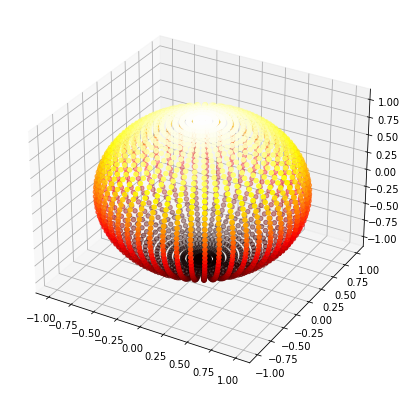

In [300]:
points = get_sphere_points(50)
plot_sphere_points(points)

2. Wygeneruj 3 różne macierze A1, A2, A3, (Ai ∈ R^3×3 ), za ich pomocą dokonaj przekształcenia sfery w elipsoidę, a następnie przedstaw wizualizację uzyskanego wyniku.

In [303]:
A1 = np.random.rand(3, 3)
A2 = np.random.rand(3, 3)
A3 = np.random.rand(3, 3)

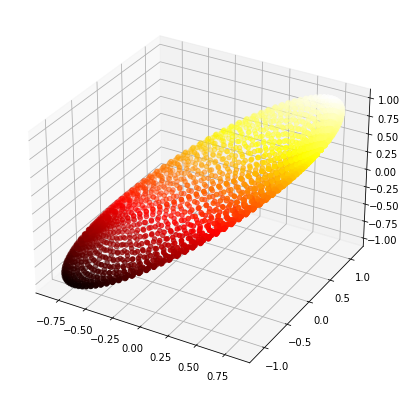

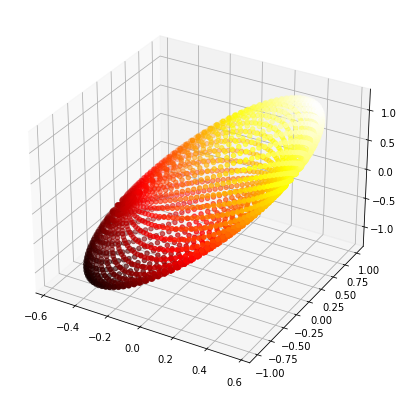

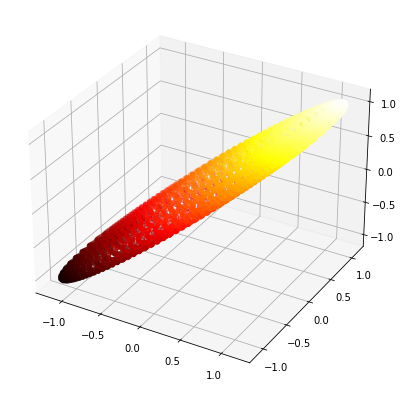

In [304]:
plot_sphere_points(A1 @ points)
plot_sphere_points(A2 @ points)
plot_sphere_points(A3 @ points)

3. Dokonaj rozkładu według wartości osobliwych (SVD) każdej macierzy Ai. Na wykresie elipsoidy odpowiadającej przekształceniu A i dodaj wizualizację jej półosi wyznaczonych za pomocą SVD.

In [311]:
def plot_svd(u, s, points, A):
    points = A @ points
    vectors =u @ np.diag(s)

    fig = plt.figure(figsize = (10, 10))
    ax = fig.gca(projection='3d')
    
    ax.scatter(points[0], points[1], points[2], c=points[2], cmap=plt.get_cmap('hot'))
    ax.quiver(0, 0, 0, vectors[0], vectors[1], vectors[2], color='black', linewidth=5)
    
    plt.show()

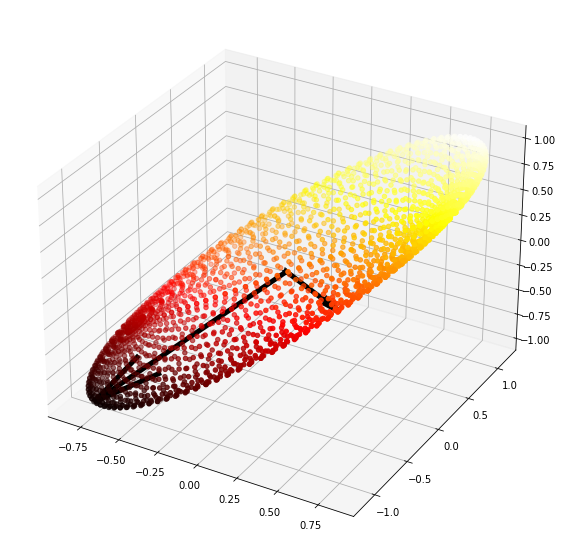

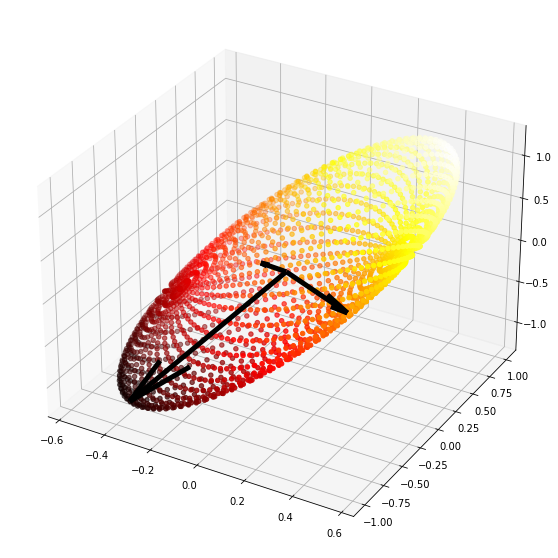

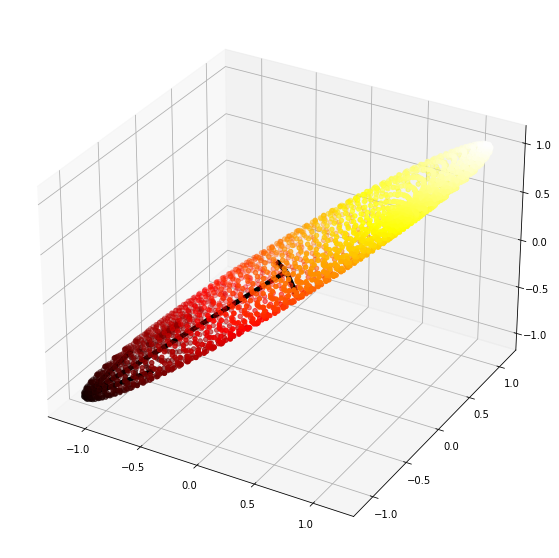

In [323]:
u1, s1, v1 = np.linalg.svd(A1)
plot_svd(u1, s1, points, A1)

u2, s2, v2 = np.linalg.svd(A2)
plot_svd(u2, s2, points, A2)

u3, s3, v3 = np.linalg.svd(A3)
plot_svd(u3, s3, points, A3)

4. Znajdź taką macierz A i , aby stosunek jej największej i najmniejszej wartości osobliwej był większy od 100. Narysuj odpowiadającą jej elipsoidę. Czym charakteryzuje się wygenerowana elipsoida i czemu tak się dzieje?

In [357]:
def singular_value_ratio(A):
    u, s, v = np.linalg.svd(A)
    return s[0]/s[-1]

In [358]:
def max_svd_matrix():
    A = np.random.rand(3,3)
    
    while singular_value_ratio(A) < 100:
        A = np.random.rand(3, 3)
    
    return A

[[0.54304772 0.19819109 0.45478623]
 [0.9797868  0.88755819 0.48503912]
 [0.86324768 0.16191133 0.75792323]]
[1.89104765 0.54176649 0.01740761]


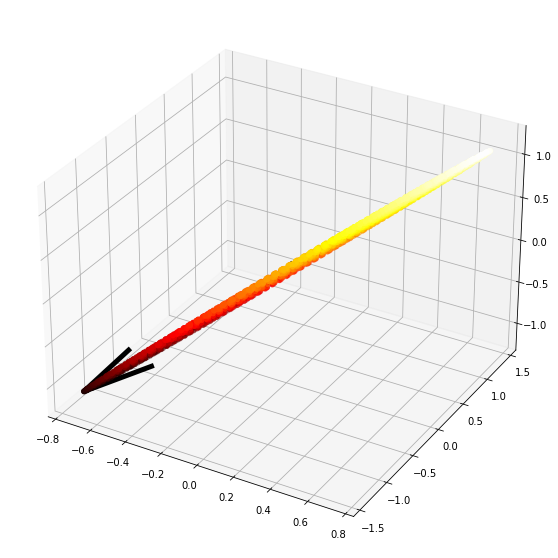

In [359]:
A_100 = max_svd_matrix()
u, s, v = np.linalg.svd(A_100)
print(A_100)
print(s)
plot_svd(u, s, points, A_100)

5. Dla wybranej macierzy A i przedstaw wizualizacje $SV_i^T, S\Sigma_iV_i^T$ oraz $SU_iΣ_iV_i^T$, gdzie $A_i = U_iΣ_iV_i^T$, a S oznacza sferę z punktu 1. Opisz jakie przekształcenia mają miejsce w kolejnych krokach.

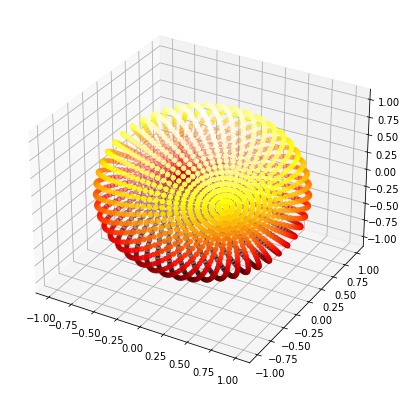

In [360]:
plot_sphere_points(v1 @ points)

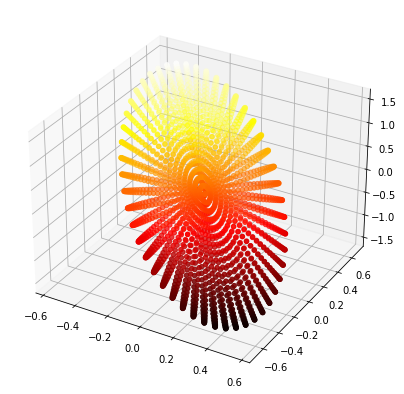

In [361]:
plot_sphere_points(v1 @ np.diag(s1) @ points)

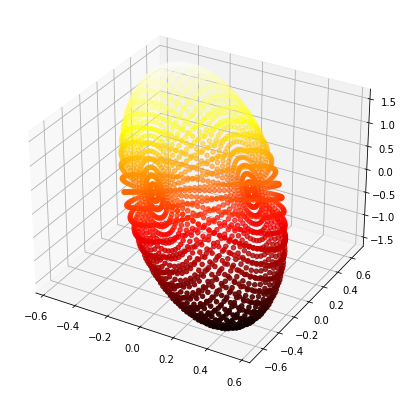

In [362]:
plot_sphere_points(v1 @ np.diag(s1) @ u1 @ points)

## 4. Układ źle uwarunkowany

In [363]:
# poczytać kincaida - strona 321

1. Rozwiąż układ równań
> 0.835x + 0.667y = 0.168 <br>
> 0.333x + 0.266y = 0.067

In [364]:
A = np.array([[0.835, 0.667], [0.333, 0.266]])
B = np.array([0.168, 0.067])

In [365]:
gauss_jordan(A, B)

array([ 1., -1.])

2. Zaburz delikatnie rozwiązanie zmieniając wartość 0.067 na 0.066 i rozwiąż ponownie. Czemu wyniki się znacząco różnią?

In [366]:
B[1] -= 0.001
gauss_jordan(A, B)

array([-665.99999998,  833.99999998])

układ jest źle uwarunkowany

3. Używając rozkładu SVD na macierzy współczynników znajdź stosunek maksymalnej do minimalnej wartości osobliwej. Porównaj to z wartościami wygenerowanymi
dla 3 losowych macierzy tego samego rozmiaru i opisz wyniki.

In [369]:
print('system matrix:')
print(singular_value_ratio(A), '\n')

print('random matrices:')
print(singular_value_ratio(np.random.rand(2, 2)))
print(singular_value_ratio(np.random.rand(2, 2)))
print(singular_value_ratio(np.random.rand(2, 2)))

system matrix:
1323759.00000188 

random matrices:
14.619268052026042
3.78783356213583
3.480218151842744


Stosunek maksymalnej wartości osobliwej do minimalnej dla macierzy głównej rozważanego układu równań jest bardzo duży.

## Wnioski

- 
- 
- 

M. Hawryluk 28.04.2021